# Notebook 2 - Propensity Score Matching (teacher notebook)


In this notebook we'll look at a classic economics dataset (LaLonde R, 1986) and try to calculate propensity scores and estimate a basic causal treatment effect.

In [1]:
import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Windows users: replace the following line with `df = pd.read_csv(r"..\..\data\lalonde.csv")`
df = pd.read_csv("../../data/lalonde.csv")

The LaLonde dataset should contain the following 12 columns. This is data from a set of individuals received a job training course (that is the treatment). It was hypothesized that this treatment would improve their 1978 real earnings. 

age<br>
   $\;\;\;\;\;\;$age in years.<br>
educ<br>
    $\;\;\;\;\;\;$years of schooling.<br>
black<br>
    $\;\;\;\;\;\;$indicator variable for blacks.<br>
hisp<br>
    $\;\;\;\;\;\;$indicator variable for Hispanics.<br>
married<br>
    $\;\;\;\;\;\;$indicator variable for martial status.<br>
nodegr<br>
    $\;\;\;\;\;\;$indicator variable for high school diploma.<br>
re74<br>
    $\;\;\;\;\;\;$real earnings in 1974.<br>
re75<br>
    $\;\;\;\;\;\;$real earnings in 1975.<br>
re78<br>
    $\;\;\;\;\;\;$real earnings in 1978.<br>
u74<br>
    $\;\;\;\;\;\;$indicator variable for earnings in 1974 being zero.<br>
u75<br>
    $\;\;\;\;\;\;$indicator variable for earnings in 1975 being zero.<br>
treat<br>
    $\;\;\;\;\;\;$an indicator variable for treatment status.<br>

Let's take a look at a few observations

In [3]:
df.head()

,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat
0,37,11,1,0,1,1,0.0,0.0,9930.05,1,1,1
1,22,9,0,1,0,1,0.0,0.0,3595.89,1,1,1
2,30,12,1,0,0,0,0.0,0.0,24909.50,1,1,1
3,27,11,1,0,0,1,0.0,0.0,7506.15,1,1,1
4,33,8,1,0,0,1,0.0,0.0,289.79,1,1,1


Adding an ID column and restricting the dataset to a few relevant columns

In [4]:
df['ID'] = range(0,445)

In [5]:
df = df[['ID', 'age', 'educ', 'black', 'hisp', 'married', 're78', 'treat']]

## First, let's calculate the "raw" treatment effect without any adjustment for confounding 

This is us taking a very naive (and likely biased) look at the results. There may be a negative treatment effect, or none, or positive, because there is likely confounding going on. That's okay for now, we just want to see where we're starting from.

<div class="alert alert-success">
    <h3>EXERCISE: What are the average earnings from the treated group?</h3>
</div>

In [6]:
# Get the average earnings from the treated group
raw_outcome_treated = df['re78'][df['treat'] == 1].mean()

<div class="alert alert-success">
    <h3>EXERCISE: What are the average earnings from the untreated group?</h3>
</div>

In [7]:
# Get the average earnings from the untreated group
raw_outcome_untreated = df['re78'][df['treat'] == 0].mean()

<div class="alert alert-success">
    <h3>EXERCISE: What is the difference between these two averages? This is the raw treatment effect.</h3>
</div>

In [8]:
# The raw treatment effect is...
print(round(raw_outcome_treated - raw_outcome_untreated, 2))

1794.34


## Naively, it appears that the job training course (AKA the treatment) had an effect of adding an additional $1794 dollars to one's annual earning. Let's get a sense of the variability around this estimate, by calculating 95% bootstrapped confidence intervals.

In [9]:
# First, let's create a function to more elegantly pull out the raw treatment effect from a LaLonde dataset

def get_raw_treatment(dataframe):
    """
    Extracts a raw treatment effect from a LaLonde dataset. Assumes the treatment column is named `treat` and the outcome column is named `re78`
    
    Args:
        dataframe: the pandas dataframe of interest
        
    Returns: Float corresponding to raw treatment effect
    """
    return dataframe.groupby('treat')['re78'].mean().sort_index().diff().iloc[1]

In [10]:
# Let's obtain 1000 bootstrap replicates of our original dataset

boot_results = []

for rep in range(0,10000):
    boot_results.append(
        get_raw_treatment(
            df.sample(frac = 1, replace = True)
        )
    )

In [11]:
# Now find the 2.5 and 97.5 percentile of this list's values and you have the empirical, bootstrap confidence intervals
np_boot_results = np.array(boot_results)
print(f"({round(np.percentile(np_boot_results, 2.5), 2)}, {round(np.percentile(np_boot_results, 97.5), 2)})")

(508.09, 3163.2)


## That's a wide confidence interval. It makes sense though, the dataset we're working with is tiny (about 450 observations).

## Now, let's try out hand at causal inference and start by creating our propensity scores

Remember, these scores take on values [0, 1.0], and represent the probability of an individual or study unit receiving the treatment. You can generate these by creating a model that takes in all covariates and tries to predict treatment status.

Let's first do some light exploratory work...

<AxesSubplot:ylabel='Frequency'>

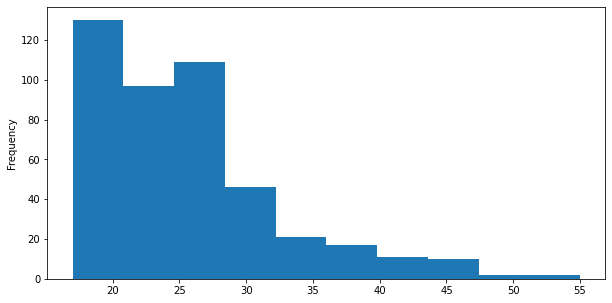

In [12]:
df['age'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

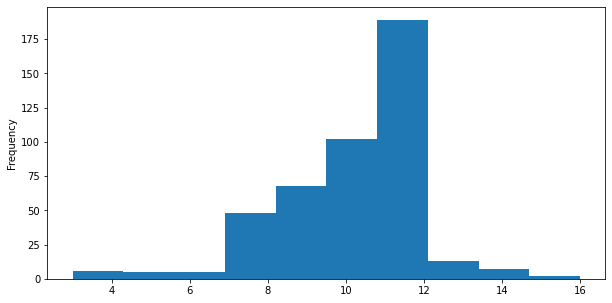

In [13]:
df['educ'].plot.hist()

In [14]:
df.describe()

,ID,age,educ,black,hisp,married,re78,treat
count,445.000000,445.000000,445.000000,445.000000,445.00000,445.000000,445.000000,445.000000
mean,222.000000,25.370787,10.195506,0.833708,0.08764,0.168539,5300.765138,0.415730
std,128.604691,7.100282,1.792119,0.372762,0.28309,0.374766,6631.493362,0.493402
min,0.000000,17.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,111.000000,20.000000,9.000000,1.000000,0.00000,0.000000,0.000000,0.000000
50%,222.000000,24.000000,10.000000,1.000000,0.00000,0.000000,3701.810000,0.000000
75%,333.000000,28.000000,11.000000,1.000000,0.00000,0.000000,8124.720000,1.000000
max,444.000000,55.000000,16.000000,1.000000,1.00000,1.000000,60307.900000,1.000000


In [15]:
# Let's scale our continuous covariates
features = df[['age', 'educ']]

# Use scaler of choice; here Standard scaler is used
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

df[['scaled_age', 'scaled_educ']] = features

In [16]:
df.head()

,ID,age,educ,black,hisp,married,re78,treat,scaled_age,scaled_educ
0,0,37,11,1,0,1,9930.05,1,1.639696,0.449412
1,1,22,9,0,1,0,3595.89,1,-0.475274,-0.667841
2,2,30,12,1,0,0,24909.50,1,0.652710,1.008039
3,3,27,11,1,0,0,7506.15,1,0.229716,0.449412
4,4,33,8,1,0,0,289.79,1,1.075704,-1.226468


In [17]:
ps_model = LogisticRegression(penalty = 'none').fit(X = df[['scaled_age', 'scaled_educ', 'black', 'hisp', 'married']], y = df['treat'])

In [18]:
# Typically it would be good to assess model performance the usual way (creating a training and test set, calculating accuracy, recall, precision, etc.)
# But for the purposes of this tutorial, let's skip that and assume it's a decent model

df['pro_score'] = ps_model.predict_proba(X = df[['scaled_age', 'scaled_educ', 'black', 'hisp', 'married']])[:,1]

## That wasn't so bad! Now we have our propensity scores as a column in the dataframe

<div class="alert alert-success">
    <h3>EXERCISE: Explore the propensity scores with a univariate analysis. How are they distributed? What are the min and max values?</h3>
</div>

In [19]:
df.head()

,ID,age,educ,black,hisp,married,re78,treat,scaled_age,scaled_educ,pro_score
0,0,37,11,1,0,1,9930.05,1,1.639696,0.449412,0.504408
1,1,22,9,0,1,0,3595.89,1,-0.475274,-0.667841,0.266263
2,2,30,12,1,0,0,24909.50,1,0.652710,1.008039,0.450044
3,3,27,11,1,0,0,7506.15,1,0.229716,0.449412,0.426711
4,4,33,8,1,0,0,289.79,1,1.075704,-1.226468,0.398769


In [20]:
edcf = ECDF(df['pro_score'])

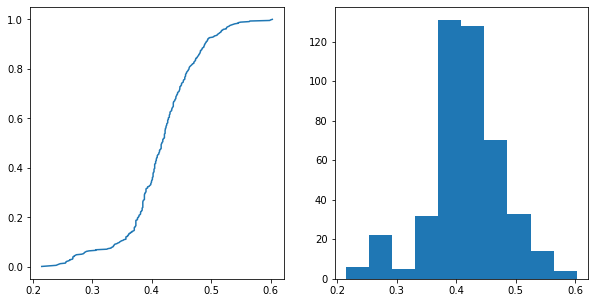

In [21]:
plt.subplot(1, 2, 1)
plt.plot(edcf.x, edcf.y)
plt.subplot(1, 2, 2)
_ = plt.hist(df['pro_score'])

<AxesSubplot:xlabel='pro_score', ylabel='Density'>

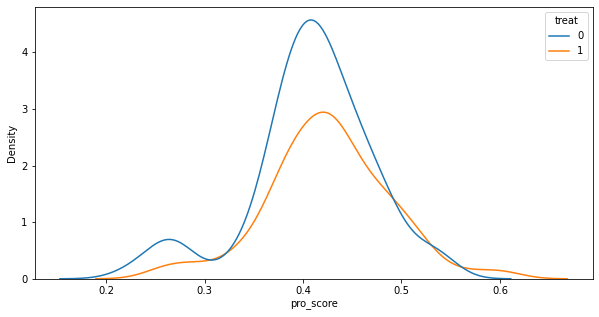

In [22]:
# Density plot of propensity scores by treatment status

sns.kdeplot(x = df['pro_score'], hue = df['treat'])

## Now let's match up our treated and "control" groups based on propensity scores

We're going to use "caliper" matching. That is, you specify a small range in which it's okay to say two propensity scores are similar enough. One standard approach is to use a fraction of the standard deviation of the propensity scores. In this example, let's use a quarter of the standard deviation.

In [23]:
caliper = np.std(df['pro_score']) / 4
print(f'Caliper radius is: {round(caliper, 4)}')

Caliper radius is: 0.0157


In [24]:
# We'll use sklearn's NearestNeighbors algorithm to clustering in 1-dimension (with the propensity scores).

knn = NearestNeighbors(n_neighbors=10, radius=caliper)
knn.fit(df['pro_score'].to_numpy().reshape(-1,1))

NearestNeighbors(n_neighbors=10, radius=0.01569750373048551)

In [25]:
# Common support distances and indexes
distances , indexes = knn.kneighbors(
   df['pro_score'].to_numpy().reshape(-1,1),
    n_neighbors=10
)

In [26]:
# Now let's do the linking of treated and untreated individuals

def perfom_matching(row, indexes, dataframe):
    current_index = int(row['index'])
    prop_score_logit = row['pro_score']
    for idx in indexes[current_index,:]:
        if (current_index != idx) and (row['treat'] == 1) and (dataframe.loc[idx]['treat'] == 0):
            return int(idx)
         
df['matched_element'] = df.reset_index().apply(perfom_matching, axis = 1, args = (indexes, df))

In [27]:
# Drop any missing values in this column
df2 = df.dropna(subset = ["matched_element"])

In [28]:
df2.head()

,ID,age,educ,black,hisp,married,re78,treat,scaled_age,scaled_educ,pro_score,matched_element
0,0,37,11,1,0,1,9930.05,1,1.639696,0.449412,0.504408,305.0
1,1,22,9,0,1,0,3595.89,1,-0.475274,-0.667841,0.266263,389.0
2,2,30,12,1,0,0,24909.50,1,0.652710,1.008039,0.450044,260.0
3,3,27,11,1,0,0,7506.15,1,0.229716,0.449412,0.426711,382.0
4,4,33,8,1,0,0,289.79,1,1.075704,-1.226468,0.398769,403.0


In [29]:
df3 = df2.copy()

# Here we put together a final dataset with both the treated and untreated individuals
# Iterating over a pandas dataframe is painfully slow and not recommended, but we're working with tiny data here so it isn't a problem
for _, row in df2.iterrows():
    match_row = df.iloc[int(row['matched_element'])]
    df3 = df3.append(match_row)

In [30]:
df3.reset_index(inplace = True)

In [31]:
df3['treat'].value_counts()

1.0    185
0.0    185
Name: treat, dtype: int64

## Fantastic, we now our matched dataset of 185 treated and 185 "control" participants. Now let's do some diagnostic work to ensure the matching worked well.

<AxesSubplot:xlabel='pro_score', ylabel='Density'>

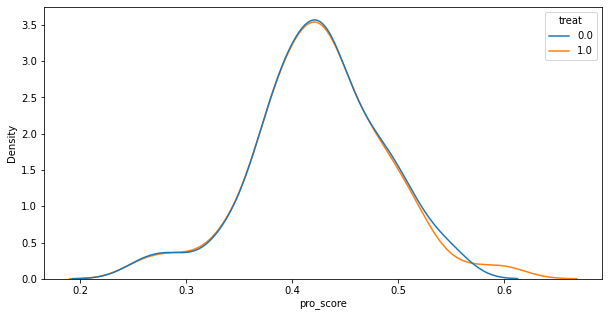

In [32]:
# Notice how much more similar the two distributions are than before...

sns.kdeplot(x = df3['pro_score'], hue = df3['treat'])

In [33]:
def cohenD (dataframe, column):
    """
    Calculates Cohen’s D (a standard score that summarizes the difference in terms of the number of standard deviations).
    
    Args:
        dataframe: the pandas dataframe of interest
        column: the covariate name of interest
        
    Returns: a float corresponding to Cohen's D. Larger number indicates greater difference.
    """
    treated_metric = dataframe[dataframe['treat'] == 1][column]
    untreated_metric = dataframe[dataframe['treat'] == 0][column]
    
    d = (treated_metric.mean() - untreated_metric.mean()) / math.sqrt(
        (
            (treated_metric.count() - 1) * treated_metric.std() ** 2
            + (untreated_metric.count() - 1) * untreated_metric.std() ** 2
        )
    / (treated_metric.count() + untreated_metric.count() - 2)
    )

    return d

In [34]:
data = []
cols = ['scaled_age', 'scaled_educ']
for cl in cols:
    data.append([cl,'before', cohenD(df,cl)])
    data.append([cl,'after', cohenD(df3,cl)])

In [35]:
res = pd.DataFrame(data, columns=['variable','matching','Cohen_D_difference'])

Notice that the two continuous covariates differ less between treatment and "control" groups after matching

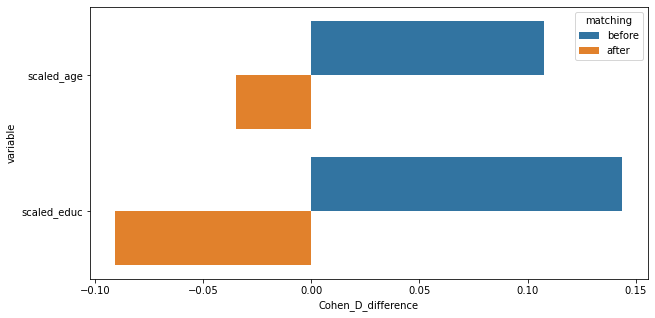

In [36]:
sn_plot = sns.barplot(data = res, y = 'variable', x = 'Cohen_D_difference', hue = 'matching', orient='h')

Similarly, the proportion of positive values among binary covariates is closer after matching

In [37]:
data = []
cols = ['educ', 'black', 'hisp', 'married']
for cl in cols:
    data.append([cl,'before', abs(df[df['treat'] == 1][cl].mean() - df[df['treat'] == 0][cl].mean())])
    data.append([cl,'after', abs(df3[df3['treat'] == 1][cl].mean() - df3[df3['treat'] == 0][cl].mean())])

In [38]:
res = pd.DataFrame(data, columns=['variable','matching','abs_diff_in_class_proportion'])

For the most part, the differences in binary covariates between treated and untreated get smaller too after matching.

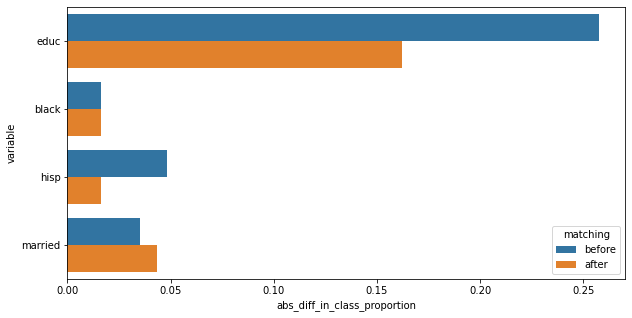

In [39]:
sn_plot = sns.barplot(data = res, y = 'variable', x = 'abs_diff_in_class_proportion', hue = 'matching', orient='h')

## We can now calculate the Average Treatment Effect Among the Treated (ATT)

<div class="alert alert-success">
    <h3>EXERCISE: In the matched dataset with 185 treated and 185 untreated individuals, what is the treatment effect? Remember, this is the difference between the average outcome value in treated minus that of the untreated group.</h3>
</div>

In [40]:
# The PSM-corrected treatment effect is...
# Hint: You'll want to use the `df3` dataframe, since this is the matched dataset of 185 treated and 185 untreated individuals
print(round(df3[df3['treat'] == 1]['re78'].mean() - df3[df3['treat'] == 0]['re78'].mean(), 2))

1781.11


## Interesting, notice how it's less than the raw estimate! That is because there was some mild-to-moderate confounding occurring with the covariates we did propensity score matching on. This is the corrected estimate one would use if you had to estimate the causal effect and you couldn't simply run a proper experiment.

#### If you really wanted to, you could obtain a confidence interval around this estimate. Like we did at the start of this notebook, you would need to repeat the following thousands of times and note the 2.5th and 97.5th percentile values of Average Treatment Effects Among the Treated:

1) Draw a sample (of same size as your dataset) with replacement
2) Generate a propensity score model and propensity score values
3) Caliper match on them as we did above
4) Calculate the ATT as you did in the cell above

